#### Importing Libraries

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Define the file path
file_path = '00000.npz'

# Attempt to load the data
try:
    data = np.load(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}")
    exit()
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

# Extract vertices and lines
vertices = data.get('vertices')
edges = data.get('lines')

# Check if the data exists
if vertices is None or edges is None:
    print("Vertices or lines data is missing in the file")
    exit()

# for getting the floorplan from the 3d wireframe mesh
floor_z_level = -0.12303486
floor_vertices_mask = np.isclose(vertices[:, 2], floor_z_level)

floor_vertices_indices = np.where(floor_vertices_mask)[0]

floor_vertices = vertices[floor_vertices_mask]

floor_edges = [edge for edge in edges if edge[0] in floor_vertices_indices and edge[1] in floor_vertices_indices]

floor_edges = np.array(floor_edges)


#### Viewing in the 3D

In [4]:
# Create a LineSet object
line_set = o3d.geometry.LineSet()

# Set the points (vertices) and lines (edges)
line_set.points = o3d.utility.Vector3dVector(floor_vertices)
line_set.lines = o3d.utility.Vector2iVector(floor_edges)

# Visualize the 2D floor plan
o3d.visualization.draw_geometries([line_set])

#### Extracting the coordinates and plotting them matplot.lib

In [83]:
# Extract the coordinates of the vertices for plotting
x_coords = floor_vertices[:, 0]
y_coords = floor_vertices[:, 1]

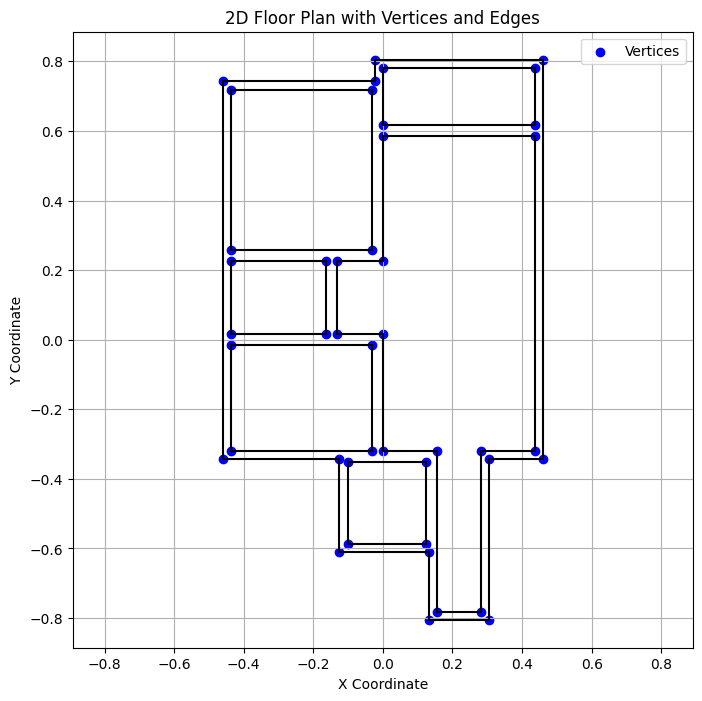

In [84]:
# Map original indices to filtered indices
index_mapping = {original_index: new_index for new_index, original_index in enumerate(floor_vertices_indices)}

# Convert floor_edges indices based on the new mapping
mapped_floor_edges = []
for edge in floor_edges:
    if edge[0] in index_mapping and edge[1] in index_mapping:
        mapped_floor_edges.append([index_mapping[edge[0]], index_mapping[edge[1]]])
mapped_floor_edges = np.array(mapped_floor_edges)

# Plot the floor vertices
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Vertices')

# Plot the mapped edges
for edge in mapped_floor_edges:
    x_values = [x_coords[edge[0]], x_coords[edge[1]]]
    y_values = [y_coords[edge[0]], y_coords[edge[1]]]
    plt.plot(x_values, y_values, c='black')

plt.title('2D Floor Plan with Vertices and Edges')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()



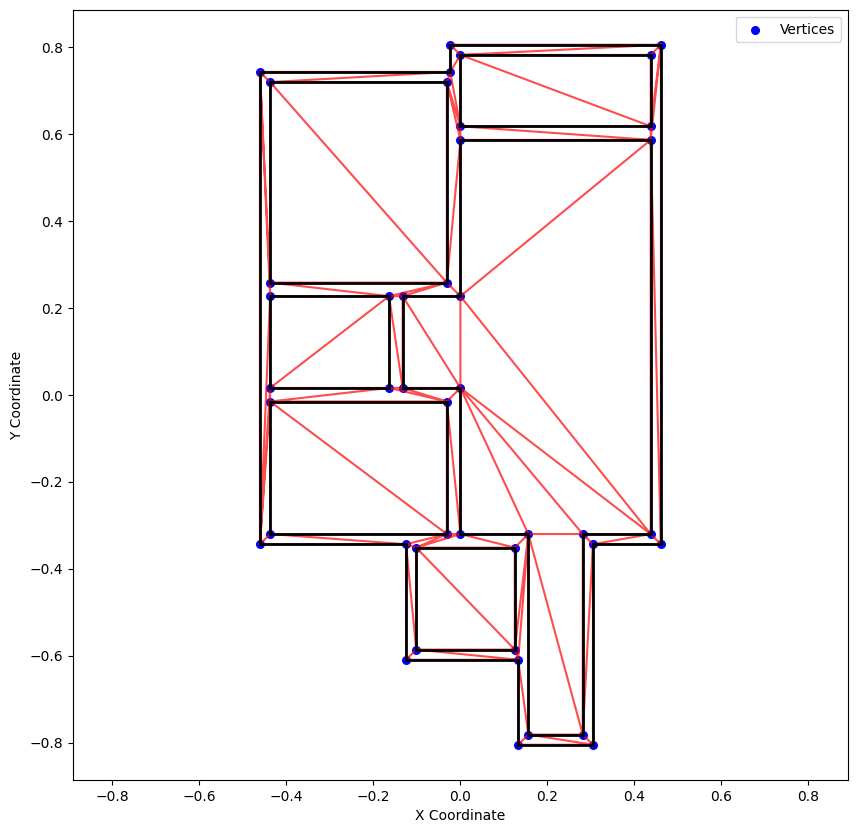

In [103]:
# Prepare data for triangulation
points = floor_vertices[:, :2]  # We only need x and y coordinates
segments = mapped_floor_edges

# Create the triangulation input dictionary
tri_input = {
    'vertices': points,
    'segments': segments
}

# Perform constrained Delaunay triangulation
tri_output = triangulate(tri_input, 'p')

# Extract triangulation results
triangles = tri_output['triangles']
tri_points = tri_output['vertices']

# Plot the results
plt.figure(figsize=(10, 10))

# Plot vertices
plt.scatter(x_coords, y_coords, c='blue', marker='o', s=30, label='Vertices')

# Plot original edges
for edge in mapped_floor_edges:
    x_values = [x_coords[edge[0]], x_coords[edge[1]]]
    y_values = [y_coords[edge[0]], y_coords[edge[1]]]
    plt.plot(x_values, y_values, c='black', linewidth=2)

# Plot triangulation
plt.triplot(tri_points[:, 0], tri_points[:, 1], triangles, 'r-', lw=1.5, alpha=0.7)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.legend()
plt.show()

#### Writing the triangulated faces to a mesh

In [102]:
vertices_3d = np.column_stack((tri_points, np.full(len(tri_points), floor_z_level)))

# Create faces (triangles are already in the correct format for faces)
faces = triangles + 1  # OBJ files use 1-based indexing

def write_obj(file_path, vertices, faces):
    with open(file_path, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]} {face[1]} {face[2]}\n")

write_obj('floor_plan_3d.obj', vertices_3d, faces)

OBJ file has been created: floor_plan_3d.obj
